
# <p style="text-align: center;">MIS382: Advanced Predictive Modeling</p>
# <p style="text-align: center;">Assignment 3</p>
## <p style="text-align: center;">Won Lee (Wl6289), Sam Malcolm (STM2334) </p>
## <p style="text-align: center;">Total points: 75</p>
## <p style="text-align: center;">Due: Tuesday, October 23rd, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  **Please include the name and UTEID for both students on all submitted files (including this notebook).** In addition, please make sure that **your filename includes your EID** (ex. ss324.jpynb or ss324_mj345.jpypb).

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1a - Stochastic Gradient Descent (25pts)

#### 1. (5pts) Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2 $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook.








<img src = "https://imgur.com/bNQQcdx.png">

#### 2. (15pts) Write Python code for an SGD solution to the non-linear model $$ y = w_0 + w_1x_1 + w_2x_1^2 + w_3x_1x_2$$ 

Try to format similarly to scikit-learn's models. Your class should take as input the learning_rate, regularization_constant and number of epochs. 

The fit method must take as input X,y and a choice of update_rule as 'sgd' or 'sgd_momentum' or 'rmsprop'(Notes on implementation below). 

The _predict_ method takes an X value (optionally, an array of values). 

Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [.0001, .001, .01, 0.1, 1, 10, 100] and regularization constants in the range: [0,10,100] . 

Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD, SGD-Momentum and RMSProp. I.e., you should have one plot of MSE and another for the parameter updates for SGD, SGD-Momentum and RMSProp (6 plots total).

In [8]:
# https://gluon.mxnet.io/chapter06_optimization/gd-sgd-scratch.html
# https://machinelearningmastery.com/implement-linear-regression-stochastic-gradient-descent-scratch-python/
# https://towardsdatascience.com/linear-regression-using-gradient-descent-in-10-lines-of-code-642f995339c0
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/neuralnet.py

import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import *
import glob

data1 = pd.read_csv('samples.csv', index_col = 0)
X = data1.drop(columns='y').values
y = data1['y']

class sgd:
    def __init__(self, learning_rate, regularization_constant, epochs, params_init = None):
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant
        self.epochs = epochs
        if params_init is not None:
            self.params = np.array(params_init)
        else:
            self.params = np.zeros(4)

    def fit(self, x, y, update_rule = 'SGD'):
        def evaluate_gradient(data, params, reg):
            y, x1, x2 = data
            w0, w1, w2, w3 = params
            g0 = -2*(y - (w0 + w1*x1 + w2*x1*x1 + w3*x1*x2)) + reg * w0
            g1 = -2*x1*(y - (w0 + w1*x1 + w2*x1*x1 + w3*x1*x2)) + reg * w1
            g2 = -2*x1*x1*(y - (w0 + w1*x1 + w2*x1*x1 + w3*x1*x2)) + reg * w2
            g3 = -2*x1*x2*(y - (w0 + w1*x1 + w2*x1*x1 + w3*x1*x2)) + reg * w3
            return np.array([g0,g1,g2,g3])        
        self.w = []
        self.w0 = []
        self.w1 = []
        self.w2 = []
        self.w3 = []
        self.mse = []
        n = x.shape[0]
        x1 = x[:,0]
        x2 = x[:,1]
        data = np.column_stack((y,x))
        cache = np.zeros(4)
        for i in range(self.epochs):   
            for d in data:
                params_grad = evaluate_gradient(d, self.params, self.regularization_constant)
                if update_rule == 'RMSprop':
                    cache = 0.9*cache + 0.1*params_grad**2
                    self.params = self.params - self.learning_rate/np.sqrt(cache + 1e-6) * params_grad
                if update_rule == 'Momentum':
                    cache = 0.9*cache - (self.learning_rate)*params_grad
                    self.params = self.params + cache
                else:
                    self.params = self.params - self.learning_rate * params_grad
            predict = self.params[0] * np.ones(n) + self.params[1]*x1 + self.params[2]*x1*x1 + self.params[3]*x1*x2
            self.w.append(self.params)
            self.w0.append(self.params[0])
            self.w1.append(self.params[1])
            self.w2.append(self.params[2])
            self.w3.append(self.params[3])
            self.mse.append(mean_squared_error(y,predict))
        
    
    def predict(self, x):
        x1 = x[:,0]
        x2 = x[:,1]
        n = x.shape[0]
        predict = self.params[0] * np.ones(n) + self.params[1]*x1 + self.params[2]*x1*x2 + self.params[3]*x2
        return predict

MSE_sgd = []
MSE_grads = []
lr_set = [.0001, .001, .01, 0.1, 1, 10, 100]
reg_set = [0,10,100]
for i in lr_set:
    for value in reg_set:
        try:
            gd = sgd(i,value,10)
            gd.fit(x,y,update_rule = 'SGD')
            MSE_sgd.append((i,value,gd.mse[-1]))
        except:MSE_sgd.append((i,value,99999))
        try:
            gd = sgd(i,value,10)
            gd.fit(x,y,update_rule = 'adagrad')
            MSE_grads.append((i,value,gd.mse[-1]))
        except:MSE_grads.append((i,value,99999))
                       
MSE_sgd.sort(key = lambda x: x[2])
MSE_grads.sort(key = lambda x: x[2])
options = [[0.001,0,'sgd'],[0.0001,0,'momentum'],[0.001,0,'rmsprop']]
def run_sgd(lr,rc,rule):
    sgd = sgd_apm(lr, rc, 15)
    sgd.fit(X,y,rule)
    return sgd.mse
for i in options:
    mse = run_sgd(i[0],i[1],i[2])
    
best_sgd = [(MSE_sgd[0][0],MSE_sgd[0][1]),(MSE_sgd[1][0],MSE_sgd[1][1]),(MSE_sgd[2][0],MSE_sgd[2][1])]
best_grad = [(MSE_grads[0][0],MSE_grads[0][1]),(MSE_grads[1][0],MSE_grads[1][1]),(MSE_grads[2][0],MSE_grads[2][1])]
print ('SGD LR = {}, REG = {}, MSE = {}'.format(MSE_sgd[0][0],MSE_sgd[0][1],MSE_sgd[0][2]))

SGD LR = 0.0001, REG = 0, MSE = 99999


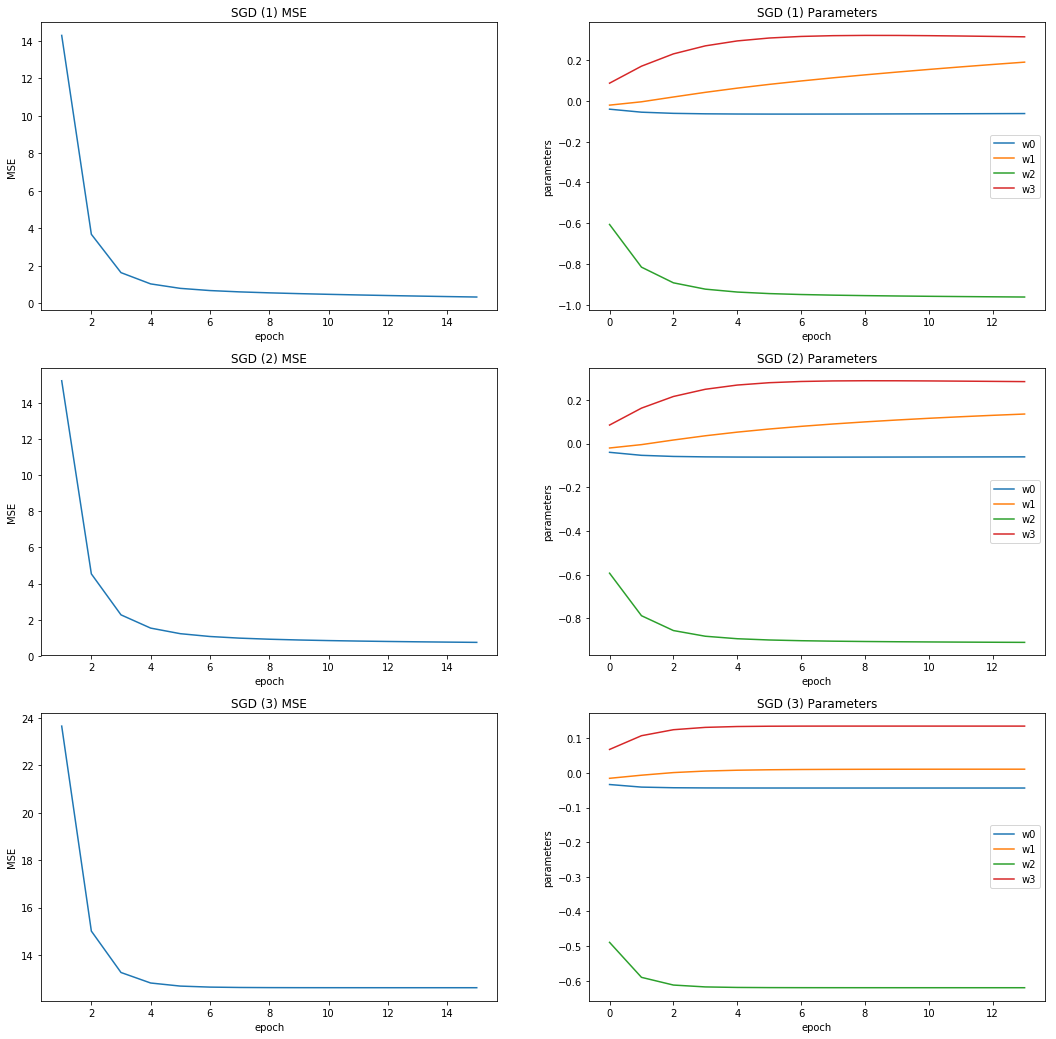

In [30]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = subplots(3,2,figsize = (18,18))
ax = [ax1,ax2,ax3,ax4,ax5,ax6]
epoch = range(1,16)
for (i,(lr,reg)) in enumerate(best_sgd):
    gd = sgd_apm(lr,reg,15)
    gd.fit(x,y,update_rule = 'SGD')
    mse = gd.mse
    ax[2*i].plot(epoch,mse,label='MSE')
    ax[2*i].set_title('SGD ({}) MSE'.format(i+1))
    ax[2*i].set_xlabel('epoch')
    ax[2*i].set_ylabel('MSE')
    ax[2*i+1].plot(range(len(gd.w0)-1),gd.w0[:-1],label='w0')
    ax[2*i+1].plot(range(len(gd.w1)-1),gd.w1[:-1],label='w1')
    ax[2*i+1].plot(range(len(gd.w2)-1),gd.w2[:-1],label='w2')
    ax[2*i+1].plot(range(len(gd.w3)-1),gd.w3[:-1],label='w3')
    ax[2*i+1].set_title('SGD ({}) Parameters'.format(i+1))
    ax[2*i+1].set_xlabel('epoch')
    ax[2*i+1].set_ylabel('parameters')
    ax[2*i+1].legend()

#### 3. (2pts) Report the MSE at the end of 15 epochs for both combinations.

In [9]:
options = [[0.001,0,'SGD:'],[0.0001,0,'Momentum:'],[0.001,0,'RMSprop:']]
def sgd(lr, rc, rule):
    sgd = sgd_apm(lr, rc, 15)
    sgd.fit(X,y,rule)
    return sgd.mse

j=0

for i in options:
    mse = run_sgd(i[0],i[1],i[2])
    print (str(options[j][2]), ' ',mse[14])
    j+=1

SGD:   0.002692724650811375
Momentum:   0.3375618808619165
RMSprop:   0.002692724650811375


#### 4. (3pts) Based on the experiments, which of the 3 techniques allowed for larger initial setting of the learning_rate? Why?

https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a

The learning rate of RMSprop allows for a larger initial learning rate. We adjust according to the sum of the gradient and we adapt the learning rate by dividing it by the sum. This allows this particular technique to have a larger initial learning rate without overshooting its target.

# Notes on SGD with momentum
Momentum helps accelerate SGD in relevant direction and dampens the oscillations. It tries to maintain the direction in which the gradient vector was already pointing and adjusts the direction slowly with the new gradients. The steps can be listed below :
1. v[t] = mu * v[t-1] - (learning_rate)*(gradient)
2. w = w + v

Set mu = 0.90. Initialize v with zeros.


# Notes on RMSProp
RMSProp (http://ruder.io/optimizing-gradient-descent/) differs from vanilla SGD in that the learning rate of each weight changes over updates. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.  In particular, it uses a moving average of squared gradients as cache. The learning_rate is divided by the cache, resulting in a different learning rate for each weight. A consequence of this update rule is that weights that have already seen large gradients (made large jumps) make smaller updates in subsequent iterations.
Specifically, the steps can be listed as below:
1. cache = (decay_rate)*(cache) + (1 - decay_rate)*(gradients^2) 
2. weights = weights - ((learning_rate)/sqrt(cache+1e-6))*gradients

Use decay_rate = 0.90. Initialize cache with zeros.

# (Optional) Notes on Training with Gradient Descent
1. Compute error: This consists of a prediction error and a regularization term. From an implementation perspective, this is a function that takes as input the truth, prediction and regularization hyperparameter and returns an error
2. Compute gradients: Take a derivative of the error in terms of the weights. This can be modelled as a function that takes as input the error and features and returns the gradients for each weight
3. Update weights: Weight updates can be done using vanilla SGD or adaptive techniques. The update function takes as inputs the gradient and hyperparameters and returns the new weights.

# Question 2 - Multi-layer perceptron Regressor (15 pts)

In this question, you will explore the application of Multi-layer Perceptron (MLP) regression using sklearn package in Python;
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.


We will use the OpenCL gemm kernel performance prediction dataset for this problem; https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance.

Following code will pre-process the data and split the data into training and test set using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with **random state 30** and **test_size = 0.25**.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,KFold, cross_val_score)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('sgemm_product.csv') 
data['target'] = 0.25*(data['Run1 (ms)'] + data['Run2 (ms)']+ data['Run3 (ms)'] + data['Run4 (ms)'])
y = data['target']
y = y.as_matrix()
X = data.drop(['target','Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((181200, 14), (181200,), (60400, 14), (60400,))


One more thing to use in this problem is [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on original data, use StandardScaler to make each feature centered ([Example](http://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py)). Whenever you have training and test data, fit a scaler on training data and use this scaler on test data. Here, scale only features (independent variables), not target variable y. 

## Answer

#### 1) (5pts) Use [sklearn.neural_nework.MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) to do a 5-fold cross validation using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). The cross validation must be performed on the **training data**. Use following parameter settings for MLPRegressor:

    activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42,
    batch_size=30, learning_rate_init = 0.005
    
Now, consider the following settings for the number of hidden units:
    
   (a) *hidden_layer_sizes = (2,)* 
   
   (b) *hidden_layer_sizes = (10,)*
   
   (c) *hidden_layer_sizes = (30,)*
   
   (d) *hidden_layer_sizes = (50,)*
   
   Report the average Root Mean Squared Error (RMSE) value based on your 5-fold cross validation for each model.

In [2]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [3]:
hidden = [(2,),(10,),(30,),(50,)]
kfcv = KFold(n_splits = 5)

for size in hidden:
    mlpr = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=30, learning_rate_init = 0.005, hidden_layer_sizes = size)
    scores = cross_val_score(mlpr, X_train, y_train, cv=kfcv, scoring = 'neg_mean_squared_error')    
    mean_rmse = np.sqrt(-scores).mean()
    print "hidden layer size = " + str(size) + ", RMSE = " + str(mean_rmse)

hidden layer size = (2,), RMSE = 270.23632573838324
hidden layer size = (10,), RMSE = 207.64162486331534
hidden layer size = (30,), RMSE = 179.4723696435122
hidden layer size = (50,), RMSE = 170.05567937463937


#### 2) (5pts) Now, using the same parameters used in part 1), train MLPRegressor models on the entire training set and report the RMSE score for both the trainnig and testing sets (again, use StandardScaler). Which of the four models ((a)-(d)) performs the best? Briefly analyze and discuss the results, commenting on the number of hidden units.

In [4]:
for size in hidden:
    mlpr = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=30, learning_rate_init = 0.005, hidden_layer_sizes = size)
    mlpr.fit(X_train, y_train)
    y_fit = mlpr.predict(X_train)
    y_pred = mlpr.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_fit))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print "hidden layer size = " + str(size) + ", Train RMSE = " + str(train_rmse) + ", Test RMSE = " + str(test_rmse)

hidden layer size = (2,), Train RMSE = 266.35421927262047, Test RMSE = 261.7462665043765
hidden layer size = (10,), Train RMSE = 227.05583943895655, Test RMSE = 222.30985245232222
hidden layer size = (30,), Train RMSE = 209.49171628660778, Test RMSE = 208.10328043618927
hidden layer size = (50,), Train RMSE = 182.96749234517418, Test RMSE = 180.56934480329457


Model (d) performed the best with a Test RMSE of 180.569. This is considerably better than any other option. Model (d) had the most hidden units with 50. We observe the model improves as hidden units increase.

#### 3) (5pts) MLPRegressor has a built-in attribute *loss\_curve\_* which returns the loss at each epoch (misleadingly referred to as "iteration" in scikit documentation, though they use epoch in the actual code!). For example, if your model is named as *my_model* you can call it as *my\_model.loss\_curve\_* ([example](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)). Plot three curves using below conditions (a, b, c) in one figure, where *X-axis* is epoch  number and *Y-axis* is squared root of *loss\_curve\_* valu;:

   (a) *hidden_layer_sizes = (1,)* 
   
   (b) *hidden_layer_sizes = (5,)*
   
   (c) *hidden_layer_sizes = (10,)*

Text(0,0.5,'loss_curve_ value')

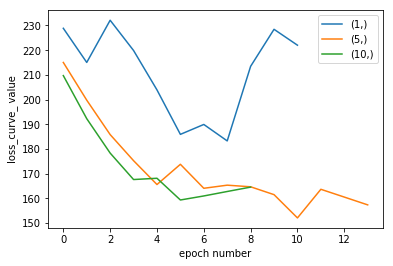

In [7]:
hidden_v2 = [(1,), (5,), (10,)]

mlpr_fits = []

for size in hidden_v2:
    mlpr = MLPRegressor(activation = 'tanh', solver = 'sgd', learning_rate='constant', random_state=42, batch_size=30, learning_rate_init = 0.005, hidden_layer_sizes = size)
    mlpr.fit(X_train, y_train)
    mlpr_fits.append(mlpr)
    
for mlpr, size in zip(mlpr_fits, hidden_v2):
    plt.plot(np.sqrt(mlpr.loss_curve_), label = size)
plt.legend()
plt.xlabel('epoch number')
plt.ylabel('loss')

# Question 3 - [Kaggle Competition] Mercedes-Benz Greener Manufacturing (25 pts)

In this problem, we are going to explore a Kaggle competition: [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing). Your goal is to obtain the best score you can in this competition.

The first step is to make a Kaggle account. Then find this competition and read the competition details and the description of the dataset. 

I have converted the categorical variables to numbers. The dataset is available as **'q3_train.csv'** and **'q3_test.csv'** along with the assignment. Please use this dataset for building your models. Upload your predicted values to kaggle to get the score.

Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any outlier and remove them).
 * Impute the missing values (if any).
 
2. Predictive Models. 
 * You have to create three models: Lasso regression, Ridge regression and multilayer perceptron. For Lasso and Ridge regression, optimize the alphas using cross validation. Multilayer perceptron can have one hidden layer. You may try other predictive models to get better scores (optional). 
3. Get a score of 0.51 or higher on the **Private Leaderboard**. Take a screenshot of your private score after submission as proof. You can click My Submissions tab to see the history of your submissions. It will show both Public Leaderboard & Private Leaderboard score. Your highes score should be visible in the screenshot.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

## Answer

<img src = "https://i.imgur.com/7xvmo4k.png">
<img src = "https://i.imgur.com/QXbzERY.png">

In [14]:
import pandas as pd
from sklearn import linear_model

train_df = pd.read_csv("q3_train.csv")
test_df = pd.read_csv("q3_test.csv")

print (test_df[:5])

X_train = train_df.drop(['ID','y'],axis=1)
Y_train = train_df['y']
Y_trainOrig = train_df['y']

X_test = test_df.drop(['ID'],axis=1)


   ID  X0  X1  X2  X3  X4  X5  X6  X8  X10  ...   X375  X376  X377  X378  \
0   1  21  23  34   5   3  26   0  22    0  ...      0     0     0     1   
1   2  42   3   8   0   3   9   6  24    0  ...      0     0     1     0   
2   3  21  23  17   5   3   0   9   9    0  ...      0     0     0     1   
3   4  21  13  34   5   3  31  11  13    0  ...      0     0     0     1   
4   5  45  20  17   2   3  30   8  12    0  ...      1     0     0     0   

   X379  X380  X382  X383  X384  X385  
0     0     0     0     0     0     0  
1     0     0     0     0     0     0  
2     0     0     0     0     0     0  
3     0     0     0     0     0     0  
4     0     0     0     0     0     0  

[5 rows x 377 columns]


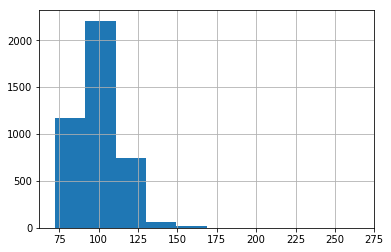

In [15]:
Y_train.hist() # Right-tailed Distribution

In [16]:
# Check for number of empty values.
print ("Number of NAs:", train_df.isna().any().sum())
train_df.dropna(inplace = True)
print (len(train_df))

Number of NAs: 0
4209


In [17]:
train_df.idxmax
print (train_df.iloc[883][:5])

train_df.describe()

ID    1770.00
y      265.32
X0      45.00
X1      19.00
X2       7.00
Name: 883, dtype: float64


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,29.760751,11.113566,17.306486,2.919696,2.997862,13.340223,6.807318,11.611309,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,13.738338,8.531001,10.899914,1.739912,0.073900,8.250832,2.916973,7.037888,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,19.000000,3.000000,8.000000,2.000000,3.000000,5.000000,6.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,35.000000,13.000000,16.000000,2.000000,3.000000,15.000000,7.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,43.000000,20.000000,25.000000,5.000000,3.000000,21.000000,9.000000,18.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,46.000000,26.000000,43.000000,6.000000,3.000000,28.000000,11.000000,24.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
import numpy as np
from scipy import stats

train_df = train_df[np.abs(train_df - train_df.mean()) <= (3 * train_df.std())] # Change 3 to 7 for MLP

print ("Number of NAs:", train_df.isna().any().sum())

Number of NAs: 268


In [19]:
print (train_df[:5])

   ID       y  X0  X1  X2  X3   X4  X5  X6  X8  ...   X375  X376  X377  X378  \
0   0  130.81  32  23  17   0  3.0  24   9  14  ...      0   0.0     1   0.0   
1   6   88.53  32  21  19   4  3.0  28  11  14  ...      1   0.0     0   0.0   
2   7   76.26  20  24  34   2  3.0  27   9  23  ...      0   0.0     0   0.0   
3   9   80.62  20  21  34   5  3.0  27  11   4  ...      0   0.0     0   0.0   
4  13   78.02  20  23  34   5  3.0  12   3  13  ...      0   0.0     0   0.0   

   X379  X380  X382  X383  X384  X385  
0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   NaN   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 378 columns]


In [21]:
train_df.describe()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4169.000000,4209.000000,4209.000000,4209.000000,4209.000000,4205.0,4209.000000,4209.000000,4209.000000,...,4209.000000,3968.0,4209.000000,4122.0,4169.0,4175.0,4177.0,4202.0,4207.0,4203.0
mean,4205.960798,100.184845,29.760751,11.113566,17.306486,2.919696,3.0,13.340223,6.807318,11.611309,...,0.318841,0.0,0.314802,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2437.608688,11.564769,13.738338,8.531001,10.899914,1.739912,0.0,8.250832,2.916973,7.037888,...,0.466082,0.0,0.464492,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,72.110000,0.000000,0.000000,0.000000,0.000000,3.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2095.000000,90.790000,19.000000,3.000000,8.000000,2.000000,3.0,5.000000,6.000000,5.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4220.000000,99.010000,35.000000,13.000000,16.000000,2.000000,3.0,15.000000,7.000000,11.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,6314.000000,108.850000,43.000000,20.000000,25.000000,5.000000,3.0,21.000000,9.000000,18.000000,...,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,8417.000000,138.190000,46.000000,26.000000,43.000000,6.000000,3.0,28.000000,11.000000,24.000000,...,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_train.iloc[:5, :8]

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13


In [23]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler()
scaler.fit(X_train.iloc[:, :8])
X_train = scaler.transform(X_train.iloc[:, :8])
print (X_train)


[[ 0.16301209  1.39348787 -0.02812155 ...  1.29211729  0.75178725
   0.33944483]
 [ 0.16301209  1.15902093  0.15538793 ...  1.77697445  1.43751106
   0.33944483]
 [-0.71055977  1.51072134  1.53170902 ...  1.65576016  0.75178725
   1.61838949]
 ...
 [-1.58413164  1.39348787  1.89872798 ... -1.61702573 -0.27679847
  -1.08160479]
 [-1.51133398  0.924554    0.70591637 ... -1.61702573  1.43751106
   1.1920746 ]
 [ 1.18217927  0.924554   -1.31268791 ... -1.61702573 -0.27679847
   1.47628453]]


In [24]:
# Remove multivariate outliers, only in non-catecgorical variables
from sklearn import svm

outliers_fraction = 0.01 
nu_estimate = 0.95 * outliers_fraction + 0.05
auto_detection = svm.OneClassSVM(gamma = 0.01, degree = 3, nu = nu_estimate)
auto_detection.fit(X_train)
evaluation_mask = auto_detection.predict(X_train)
print ("Length of DF Before MV Outlier Removal:", len(train_df))
train_df = train_df[evaluation_mask != -1]
print ("Length of DF After MV Outlier Removal:", len(train_df))


Length of DF Before MV Outlier Removal: 4209
Length of DF After MV Outlier Removal: 3962


In [26]:
from fancyimpute import KNN    

train_df = KNN(k=3).fit_transform(train_df)
train_df = pd.DataFrame(data = train_df)

print ("Number of NAs:", train_df.isna().any().sum())

print (train_df[:5])

Imputing row 1/3962 with 23 missing, elapsed time: 47.041
Imputing row 101/3962 with 2 missing, elapsed time: 47.058
Imputing row 201/3962 with 0 missing, elapsed time: 47.072
Imputing row 301/3962 with 2 missing, elapsed time: 47.090
Imputing row 401/3962 with 3 missing, elapsed time: 47.108
Imputing row 501/3962 with 3 missing, elapsed time: 47.122
Imputing row 601/3962 with 5 missing, elapsed time: 47.143
Imputing row 701/3962 with 15 missing, elapsed time: 47.163
Imputing row 801/3962 with 7 missing, elapsed time: 47.180
Imputing row 901/3962 with 0 missing, elapsed time: 47.197
Imputing row 1001/3962 with 18 missing, elapsed time: 47.213
Imputing row 1101/3962 with 2 missing, elapsed time: 47.234
Imputing row 1201/3962 with 4 missing, elapsed time: 47.257
Imputing row 1301/3962 with 17 missing, elapsed time: 47.283
Imputing row 1401/3962 with 4 missing, elapsed time: 47.306
Imputing row 1501/3962 with 3 missing, elapsed time: 47.323
Imputing row 1601/3962 with 2 missing, elapsed t

In [27]:
X_train = train_df.drop([0, 1],axis=1)
Y_train = train_df[1]
print ("Length of DF:", len(train_df))
print ("Length of X Train:",len(X_train))
print ("Length of Y Train:", len(Y_train))

Length of DF: 3962
Length of X Train: 3962
Length of Y Train: 3962


In [28]:
# First Method for Lasso
import warnings
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Setup lasso and alphas
lasso = Lasso(random_state = 50)
alphas = 10**np.linspace(10, -6, 100) * 0.5 

# Parameters for K-fold CV
tuned_parameters = [{'alpha': alphas}]
n_folds = 5

lrf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, scoring = "neg_mean_absolute_error") # avg MAE changed to neg
lrf.fit(X_train, Y_train)
scores = lrf.cv_results_['mean_test_score']
scores_std = lrf.cv_results_['std_test_score']
lrf_best = lrf.best_params_

print ("Best lasso lambda: ", lrf_best)

Best lasso lambda:  {'alpha': 0.01675801325469417}


In [29]:
# Second Method for Lasso
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

n_folds = 5
k_fold = KFold(n_folds)
lasso_alphas =  10**np.linspace(10,-6,100)*0.5                  
lasso_avg_mse = {}

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha,tol=.1)
    avg_mse = 0
    for train, test in k_fold.split(X_train):
        lasso.fit(X_train.iloc[train], Y_train.iloc[train])
        avg_mse = avg_mse + mean_squared_error(Y_train.iloc[test], lasso.predict(X_train.iloc[test]))
    lasso_avg_mse[alpha] = avg_mse / n_folds
best_alpha_lasso = min(lasso_avg_mse, key=lasso_avg_mse.get)

print("Best lasso alpha: {}".format(best_alpha_lasso))

Best lasso alpha: 0.01155064850041579


In [30]:
# First Method for Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=50)
alphas =10**np.linspace(10,-6,100)*0.5

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

rrf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring = 'neg_mean_absolute_error')
rrf.fit(X_train, Y_train)
scores = rrf.cv_results_['mean_test_score']
scores_std = rrf.cv_results_['std_test_score']
rrf_best = lrf.best_params_

print ("Best ridge lambda: ", rrf_best)

Best ridge lambda:  {'alpha': 0.01675801325469417}


In [31]:
# Second Method for Ridge
ridge_alphas =  10**np.linspace(10,-6,100)*0.5
ridge_avg_mse = {}

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    avg_mse = 0
    for k, (train, test) in enumerate(k_fold.split(X_train)):
        ridge.fit(X_train.iloc[train], Y_train.iloc[train])
        avg_mse = avg_mse + mean_squared_error(Y_train.iloc[test], ridge.predict(X_train.iloc[test])) 
    ridge_avg_mse[alpha] = avg_mse / n_folds
best_alpha_ridge = min(ridge_avg_mse, key=ridge_avg_mse.get)

print("Best ridge alpha: {}".format(best_alpha_ridge))

Best ridge alpha: 1.457526531412585


In [32]:
# First Method Results
lasso_reg = linear_model.Lasso(alpha = lrf_best['alpha'], tol=.1)#, max_iter=100000)#,tol=1)
ridge_reg = linear_model.Ridge(alpha = rrf_best['alpha'])

def fit_reg(model, name):
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    mse = mean_absolute_error(pred, Y_trainOrig)
    print("Training MSE for {0}: {1}".format(name, mse))

fit_reg(lasso_reg, "lasso")
fit_reg(ridge_reg, "ridge")

Training MSE for lasso: 12.052675984276357
Training MSE for ridge: 12.182277606094567


In [33]:
# Second Method Results
lasso_reg = linear_model.Lasso(alpha = best_alpha_lasso, tol=.1)#, max_iter=100000)#,tol=1)
ridge_reg = linear_model.Ridge(alpha = best_alpha_ridge)

def fit_reg(model, name):
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    mse = mean_absolute_error(pred, Y_trainOrig)
    print("Training MSE for {0}: {1}".format(name, mse))

fit_reg(lasso_reg, "lasso")
fit_reg(ridge_reg, "ridge")

Training MSE for lasso: 12.084854316739078
Training MSE for ridge: 12.15927836845788


In [38]:
import csv
# Test answers
lasso = Lasso(alpha = 0.01675801325469417, tol=.1)
lasso.fit(X_train, Y_train)
lasso_test = lasso.predict(X_test)
print (len(lasso_test))

ridge = Ridge(alpha= 1.457526531412585)
ridge.fit(X_train, Y_train)
ridge_test = ridge.predict(X_test)
print (len(ridge_test))

i = 0
with open('lassoPred.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator = '\n')
    writer.writerow(("ID","y"))
    while i < len(lasso_test):
        writer.writerow((test_df.iloc[i][0],lasso_test[i]))
        i += 1
i = 0
with open('ridgePred.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator = '\n')
    writer.writerow(("ID","y"))
    while i < len(ridge_test):
        writer.writerow((test_df.iloc[i][0],ridge_test[i]))
        i += 1

4209
4209


In [39]:
import csv
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_mlp = X_scaler.fit_transform(X_train)
X_test_mlp = X_scaler.fit_transform(X_test)
print (len(X_test_mlp))

MLP = MLPRegressor(hidden_layer_sizes = (10,) ,activation = 'tanh', solver = 'adam', random_state = 42,
    batch_size = 40, learning_rate_init = 0.03)
MLP.fit(X_train_mlp,Y_train)
mlp_test = MLP.predict(X_test_mlp)

i = 0

with open('MLPPred.csv', 'w') as csvfile: 
    writer = csv.writer(csvfile, delimiter=',', lineterminator = '\n')
    writer.writerow(("ID","y"))
    while i < len(mlp_test):
        writer.writerow((test_df.iloc[i][0],mlp_test[i]))
        i += 1

4209


# Question 4 - Bayes Decision Theory (10pts)

## Answer

#### a. (2pts) Explain what you understand by class-conditional likelihood, class priors, and posterior probability of a class given an input, and the relationship between them. Please define all symbols and equations used explicitly.

Class-conditional likelihood is the probability that, given a certain class (C), an input (i) of a certain feature (X) belongs to that class. This is represented as: $$P(Xi | C)$$ 

Class-priors are the probability of observing a given class (C). This is represented as: $$P(C)$$

Posterior probability is the probability that, given a certain input (i) of a feature (X), the input belongs to a certain class (C). This is represented as: $$P(C | Xi)$$

They are related by: $$P(C_{i}|X) = \frac{P(C_{i}) * P(X|C_{i})}{P(X_{i})}$$

#### b. (5pts) Suppose you want to learn a binary classifier to predict whether or not a customer will buy a TV. 

The class label is 0 if the patient does not buy and 1 if he/she does. For each customer, you are given two features, x1 is the per hour salary and x2 is the age. Assume that the class conditional distribution $p(x_1,x_2|C)$ is Gaussian. The mean salary and age of the people who do buy a TV is 40 and 27 respectively and that of those who don't is 16 and 20. Assume that both classes of customers have the same covariance given by the Identity matrix. Further, your sales data suggests that only 1 in 5 people actually bought a TV in the last few years. Mathematically derive the (optimal) Bayes decision boundary for this problem.

<img src = "https://imgur.com/KDdKtb4.png">

#### c. (3pts) Write a script to sample 100 customers from each class (C = 0; 1) under the assumed distribution and the estimated parameters and plot their features. Plot the decision boundary you obtained in the part (b) on the same plot.

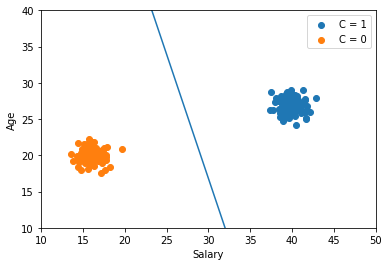

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(33)
mu1 = [40, 27]
cov1 = [[1, 0], [0, 1]]

mu2 = [16, 20]
cov2 = [[1, 0], [0, 1]]

X = np.concatenate([np.random.multivariate_normal(mu1, cov1, 100),
                    np.random.multivariate_normal(mu2, cov2, 100)])
y = np.zeros(200)
y[:100] = 1

x1 = np.arange(14, 40, 1)
x2 = (837.88-24*x1)/7

plt.scatter(X[:100, 0], X[:100, 1])
plt.scatter(X[100:, 0], X[100:, 1])
plt.legend(('C = 1','C = 0'))
plt.xlabel('Salary')
plt.ylabel('Age')
plt.ylim([10,40])
plt.xlim([10,50])
plt.plot(x1,x2,'-')